In [1]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append('..')
import os
import skimage
import time
import kaolin as kal
import tntorch as tn
import torch
import trimesh
import tqdm
import os.path as osp
import matplotlib.pyplot as plt
from t4dt.metrics import compute_metrics, hausdorff, MSDM2
from t4dt.utils import sdf2mesh, get_3dtensors_patches
from t4dt.t4dt import reduce_tucker, get_qtt_frame, qtt2tensor3d

In [2]:
ckpt = torch.load('../logs/sweeps/qtt_00032_longshort_flying_eagle_high_ranks.pt')

In [7]:
ckpt[(-0.05,0.05)]

{400: {'compressed_frames': [27D TT tensor:
   
     2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
     |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
    (0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10)(11)(12)(13)(14)(15)(16)(17)(18)(19)(20)(21)(22)(23)(24)(25)(26)
    / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
   1   2   4   8   16  32  64  128 256 400 400 400 400 400 400 400 400 400 400 256 128 64  32  16  8   4   2   1,
   27D TT tensor:
   
     2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
     |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
    (0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10)(11)(12)(13)(14)(15)(16)(17)(18)(19)(20)(21)(22)(23)(24)(25)(26)
    / \ / \ / \ / \ / \ / \ / \ / 

In [3]:
scene = ckpt[0]

KeyError: 0

In [ ]:
# coords = torch.tensor(
#     torch.load('/scratch2/data/cape_release/meshes/00032/longshort_flying_eagle/coords.pt')['coords'])
# max_rank = 400

# for i in range(1, scene.dim()):
#     lrs = scene.clone()
#     ranks_tt = scene.ranks_tt.clone()
#     ranks_tt[i + 1] = min(max_rank, ranks_tt[i + 1])
#     lrs.round_tt(rmax=ranks_tt[1:-1])
    
#     frame0_qtt = get_qtt_frame(lrs, 0)
#     frame0 = qtt2tensor3d(frame0_qtt.torch())
#     mesh = sdf2mesh(frame0, coords)
    
#     obj = trimesh.exchange.obj.export_obj(mesh, include_texture=False)
#     with open(f'./mesh_sdf_{i}.obj', 'w') as f:
#         f.write(obj)

In [ ]:
i = 14
max_rank = 400
lrs = scene.clone()
ranks_tt = scene.ranks_tt.clone()
ranks_tt[i + 1] = min(max_rank, ranks_tt[i + 1])
lrs.round_tt(rmax=ranks_tt[1:-1])

frame0_qtt = get_qtt_frame(lrs, 0)

In [ ]:
data_dir = '/scratch2/data/cape_release/'
model = '00032'
scene = 'longshort_flying_eagle'
frames = []
for frame in sorted(os.listdir(osp.join(data_dir, 'meshes', model, scene, 'posed'))):
    if frame.startswith('sdf'):
        frames.append(frame)
        
folder = osp.join(data_dir, 'meshes', model, scene, 'posed')
files = [(osp.join(folder, frame), osp.join(folder, frame[4:-2] + 'obj'))
            for frame in frames]
sdf0 = torch.load(files[0][0])
coords = torch.tensor(
    torch.load('/scratch2/data/cape_release/meshes/00032/longshort_flying_eagle/coords.pt')['coords'])

In [8]:
# 1. standartization входов и выходов
# 2. обрезка после cnn
# 3. границы - проверить значения
# 4. мб выкинуть бн
# 5. radam
# 6. сколько артифактов попадает в receptive field?
# 7. сравнить с блюром
# 8. positional encoding input for cnn?
# 9. siren?

In [9]:
# mesh_gt = sdf2mesh(sdf0['sdf'], coords)
# mesh_pred = sdf2mesh(frame0, coords)

In [10]:
# result = []

# offsets = torch.tensor([
#    [-1, -1, -1],
#    [-1, -1,  0],
#    [-1, -1,  1],
#    [-1,  0, -1],
#    [-1,  0,  0],
#    [-1,  0,  1],
#    [-1,  1, -1],
#    [-1,  1,  0],
#    [-1,  1,  1],
#    [ 0, -1, -1],
#    [ 0, -1,  0],
#    [ 0, -1,  1],
#    [ 0,  0, -1],
#    [ 0,  0,  0],
#    [ 0,  0,  1],
#    [ 0,  1, -1],
#    [ 0,  1,  0],
#    [ 0,  1,  1],
#    [ 1, -1, -1],
#    [ 1, -1,  0],
#    [ 1, -1,  1],
#    [ 1,  0, -1],
#    [ 1,  0,  0],
#    [ 1,  0,  1],
#    [ 1,  1, -1],
#    [ 1,  1,  0],
#    [ 1,  1,  1]])

# for i in range(512):
#     for j in range(512):
#         for k in range(512):
#             p = torch.tensor([i, j, k])
#             candidates = p + offsets
#             candidates.clamp_min_(0)
#             candidates.clamp_max_(511)
#             signs = torch.sign(sdf0['sdf'][candidates[:, 0], candidates[:, 1], candidates[:, 2]])
#             if torch.any(signs != torch.sign(sdf0['sdf'][p[0], p[1], p[2]])):
#                 result.append(p)

In [ ]:
[core.requires_grad_() for core in frame0_qtt.cores]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 6, 5)
        self.conv2 = nn.Conv3d(6, 16, 5)
        self.conv3 = nn.Conv3d(16, 1, 5)
        self.bn1 = torch.nn.BatchNorm3d(1)
        self.gelu = torch.nn.GELU()
        self.rec_field = 13

    def forward(self, x):
        x = self.bn1(x)
        x = self.gelu(self.conv1(x))
        x = self.gelu(self.conv2(x))
        x = self.conv3(x)
        return x


net = CNN()

In [ ]:
res = net(torch.rand((1, 1, 13, 13, 13)))

In [ ]:
idxs = torch.load('/scratch2/data/cape_release/meshes/00032/longshort_flying_eagle/near_surface_voxel_idxs_cross.pt')

In [ ]:
MIN_TSDF = -0.05
MAX_TSDF = 0.05
NUM_EPOCHS = 100
NUM_SAMPLES = 5000
RES = 512

optimizer = torch.optim.SGD(frame0_qtt.cores + list(net.parameters()), lr=1e-3)

In [ ]:
gt_sdf = sdf0['sdf']

In [ ]:
# reconstruction = tt_tucker[..., 0].torch()
# loss = torch.sqrt((reconstruction.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF) -
#         gt_sdf.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF))**2).mean()
# loss

In [ ]:
net.cuda()

In [ ]:
net.train()
for i in range(NUM_EPOCHS):
    epoch_loss = 0
    num_batches = 0
    for batch_start in range(0, idxs[frames[0]].shape[0], NUM_SAMPLES):
        optimizer.zero_grad()
        reconstruction = qtt2tensor3d(frame0_qtt.torch())
        local_idxs = idxs[frames[0]][batch_start:batch_start + NUM_SAMPLES]
        patches = get_3dtensors_patches(
            reconstruction.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF),
            net.rec_field,
            local_idxs)[:, None].cuda() / (2 * 0.005)
        predicted_voxels = net(patches).reshape(-1)
        clamped_pred = predicted_voxels.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF)
        clamped_gt = gt_sdf[local_idxs[:, 0], local_idxs[:, 1], local_idxs[:, 2]].cuda()
        clamped_gt = clamped_gt.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF) / (2 * 0.005)
        loss = ((clamped_pred - clamped_gt)**2).mean()
        loss.backward()
        epoch_loss += loss
        num_batches += 1
        print(f'Batch: {batch_start}, loss: {torch.sqrt(loss).item()}')
    print(f'Epoch: {i}, loss: {torch.sqrt(epoch_loss / num_batches).item()}')
    optimizer.step()

In [23]:
predicted_voxels.min()

tensor(-0.0737, grad_fn=<MinBackward1>)

(array([1021.,   90.,   74.,   69.,   64.,   66.,   66.,   64.,   79.,
         604.]),
 array([-0.005, -0.004, -0.003, -0.002, -0.001,  0.   ,  0.001,  0.002,
         0.003,  0.004,  0.005], dtype=float32),
 <BarContainer object of 10 artists>)

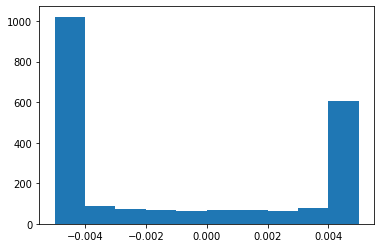

In [31]:
plt.hist(patches[0, 0].detach().cpu().numpy().ravel() * (2 * 0.005))

In [32]:
predicted_voxels.min()

tensor(-0.0737, grad_fn=<MinBackward1>)

In [33]:
predicted_voxels.max()

tensor(0.0474, grad_fn=<MaxBackward1>)

In [28]:
batch_start = 2 * NUM_SAMPLES
local_idxs = idxs[frames[0]][batch_start:batch_start + NUM_SAMPLES]
patches = get_3dtensors_patches(
    reconstruction.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF),
    net.rec_field,
    local_idxs)[:, None].cuda()

(array([1461.,   97.,   71.,   57.,   56.,   54.,   46.,   52.,   60.,
         243.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

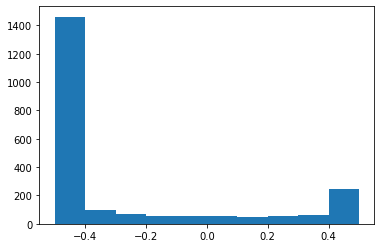

In [30]:
plt.hist(patches[0, 0].detach().cpu().numpy().ravel() / (2 * 0.005))

In [27]:
patches[12, 0].max()

tensor(-0.0034, device='cuda:0', grad_fn=<MaxBackward1>)

In [26]:
patches.min()

tensor(-0.0050, device='cuda:0', grad_fn=<MinBackward1>)

In [27]:
patches.max()

tensor(0.0050, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
net.conv3(net.gelu(net.conv2(net.gelu(net.conv1(patches))))).max()

In [29]:
predicted_voxels.max()

tensor(0.0027, grad_fn=<MaxBackward1>)

In [ ]:
1 + 1

In [71]:
patches.max()

tensor(-0.0007, device='cuda:0')

In [65]:
predicted_voxels.min()

tensor(-0.0224, grad_fn=<MinBackward1>)

In [66]:
predicted_voxels.max()

tensor(-0.0224, grad_fn=<MaxBackward1>)

In [67]:
net.conv1()

Conv3d(1, 6, kernel_size=(5, 5, 5), stride=(1, 1, 1))

In [46]:
gt_sdf[local_idxs[:, 0], local_idxs[:, 1], local_idxs[:, 2]].clamp_max(MAX_TSDF).clamp_min(MIN_TSDF).min()

tensor(-0.0050)

In [47]:
gt_sdf[local_idxs[:, 0], local_idxs[:, 1], local_idxs[:, 2]].clamp_max(MAX_TSDF).clamp_min(MIN_TSDF).max()

tensor(0.0035)

(array([  1.,   9.,  56., 101.,  83.,  80.,  57.,  53.,  44.,  28.]),
 array([-0.005     , -0.00414632, -0.00329263, -0.00243895, -0.00158526,
        -0.00073158,  0.00012211,  0.00097579,  0.00182947,  0.00268316,
         0.00353684], dtype=float32),
 <BarContainer object of 10 artists>)

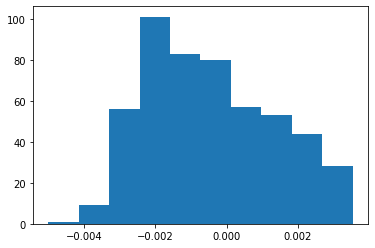

In [48]:
plt.hist(gt_sdf[local_idxs[:, 0], local_idxs[:, 1], local_idxs[:, 2]].clamp_max(MAX_TSDF).clamp_min(MIN_TSDF))

In [42]:
gt_sdf[local_idxs[:, 0], local_idxs[:, 1], local_idxs[:, 2]].clamp_max(MAX_TSDF).clamp_min(MIN_TSDF).mean()

tensor(-0.0018)

In [90]:
for i in range(NUM_EPOCHS):
    optimizer.zero_grad()
    reconstruction = qtt2tensor3d(frame0_qtt.torch())
    idxs = torch.stack([torch.randint(0, RES, (NUM_SAMPLES, )) for i in range(3)], dim=-1)
    predicted_voxels = net(
        get_3dtensors_patches(
            reconstruction.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF),
            net.rec_field,
            idxs)[:, None].cuda()).reshape(-1).cpu().reshape(-1)
    loss = ((predicted_voxels.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF) -
            gt_sdf[idxs[:, 0], idxs[:, 1], idxs[:, 2]].clamp_max(MAX_TSDF).clamp_min(MIN_TSDF))**2).mean()
    loss.backward()
    print(f'Epoch: {i}, loss: {torch.sqrt(loss).item()}')
    optimizer.step()

Epoch: 0, loss: 0.0012104306370019913
Epoch: 1, loss: 0.0009624662343412638
Epoch: 2, loss: 0.0011932689230889082
Epoch: 3, loss: 0.0010285322787240148
Epoch: 4, loss: 0.0011523171560838819
Epoch: 5, loss: 0.0012252733577042818
Epoch: 6, loss: 0.00134128553327173
Epoch: 7, loss: 0.00122573203407228
Epoch: 8, loss: 0.0011666734935715795
Epoch: 9, loss: 0.0010797488503158092
Epoch: 10, loss: 0.0011407062411308289
Epoch: 11, loss: 0.0011779924388974905
Epoch: 12, loss: 0.0012216661125421524
Epoch: 13, loss: 0.0011991276405751705
Epoch: 14, loss: 0.0011497287778183818
Epoch: 15, loss: 0.0011751375859603286
Epoch: 16, loss: 0.0012764118146151304
Epoch: 17, loss: 0.0013218183303251863
Epoch: 18, loss: 0.0014180369907990098
Epoch: 19, loss: 0.0011927252635359764
Epoch: 20, loss: 0.001428975141607225
Epoch: 21, loss: 0.0010323491878807545
Epoch: 22, loss: 0.0013092198641970754
Epoch: 23, loss: 0.001063028583303094
Epoch: 24, loss: 0.00119481619913131
Epoch: 25, loss: 0.0011696844594553113
Epoc

In [27]:
predicted_voxels.max()

tensor(-0.0190, grad_fn=<MaxBackward1>)

In [140]:
net.cpu()

CNN(
  (conv1): Conv3d(1, 6, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (conv2): Conv3d(6, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (conv3): Conv3d(16, 1, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (bn1): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu): GELU()
)

In [134]:
torch.save(net.state_dict(), '../logs/CNN_qtt_00032_fling_eagle_learning_frame0.pt')

In [10]:
state_dict = torch.load('../logs/CNN_qtt_00032_fling_eagle_learning_frame0.pt')
net.load_state_dict(state_dict)

<All keys matched successfully>

In [135]:
patch = get_3dtensors_patches(qtt2tensor3d(frame0_qtt.torch()), 512 + 13, torch.tensor([[255, 255, 255]]))

In [136]:
patch.shape

torch.Size([1, 525, 525, 525])

In [59]:
frame0_qtt.torch().min()

tensor(-0.0101)

In [60]:
frame0_qtt.torch().max()

tensor(0.0093)

In [32]:
gt_sdf[local_idxs[:, 0], local_idxs[:, 1], local_idxs[:, 2]].max()

tensor(0.0058)

In [142]:
predicted_voxels.min()

tensor(-0.1459)

In [143]:
predicted_voxels.max()

tensor(0.0824)

In [141]:
with torch.no_grad():
    predicted_voxels = net(patch[:, None])

In [146]:
coords = torch.tensor(
    torch.load('/scratch2/data/cape_release/meshes/00032/longshort_flying_eagle/coords.pt')['coords'])
mesh = sdf2mesh(predicted_voxels[0, 0, 10:-10, 10:-10, 10:-10], coords)
obj = trimesh.exchange.obj.export_obj(mesh, include_texture=False)
with open('./mesh_sdf.obj', 'w') as f:
    f.write(obj)

In [47]:
net.cuda()

CNN(
  (conv1): Conv3d(1, 6, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (conv2): Conv3d(6, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (conv3): Conv3d(16, 1, kernel_size=(5, 5, 5), stride=(1, 1, 1))
)

In [138]:
# net.eval()
# predicted_voxels0 = net(
#         get_3dtensors_patches(
#             qtt2tensor3d(frame0_qtt.torch()).clamp_max(MAX_TSDF).clamp_min(MIN_TSDF),
#             net.rec_field,
#             idxs)[:, None].cuda()).reshape(-1).cpu()

In [54]:
torch.sqrt(((predicted_voxels0.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF) -
            gt_sdf[idxs[:, 0], idxs[:, 1], idxs[:, 2]].clamp_max(MAX_TSDF).clamp_min(MIN_TSDF))**2).mean())

tensor(0.0047, grad_fn=<SqrtBackward0>)

In [55]:
predicted_voxels0.min()

tensor(-0.0008, grad_fn=<MinBackward1>)

In [56]:
predicted_voxels0.max()

tensor(0.0004, grad_fn=<MaxBackward1>)

In [34]:
idxs = torch.stack([torch.randint(0, RES, (NUM_SAMPLES, )) for i in range(3)], dim=-1)

In [9]:
(reconstruction.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF) -
        gt_sdf.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF)).abs().mean()

tensor(3.6321e-05, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [11]:
torch.sqrt((reconstruction.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF) -
        gt_sdf.clamp_max(MAX_TSDF).clamp_min(MIN_TSDF))**2).mean()

tensor(3.7646e-05, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [3]:
import skimage
import time

coords = torch.tensor(
    torch.load(
        '/scratch2/data/cape_release/meshes/00032/longshort_flying_eagle/posed/sdf_watertight_longshort_flying_eagle.000001.pt')['coords'])

In [4]:
reconstruction = tt_tucker[..., 0].torch()

In [5]:
RES = 512
t0 = time.time()
verts, faces, _, _ = skimage.measure.marching_cubes(
    reconstruction.detach().numpy(),
    level=0.,
    spacing=(coords[3:] - coords[:3]) / RES)
verts = torch.tensor(verts.copy())
faces = torch.tensor(faces.copy())
print(f'Marching cube finished. Took: {time.time() - t0} s.')

Marching cube finished. Took: 2.0360069274902344 s.


In [6]:
import trimesh

In [7]:
mesh = trimesh.base.Trimesh(vertices=verts, faces=faces)

obj = trimesh.exchange.obj.export_obj(mesh, include_texture=False)
with open('./sgd_optimised.obj', 'w') as f:
    f.write(obj)

In [33]:
torch.save(tt_tucker, '../logs/tt_tucker_sgd_optimised_r80_00032_longshort_flying_eagle.pt')